In [1]:
import time,csv
import numpy as np

from TDD.TDD import global_norm

In [2]:
from TDD.TDD import Ini_TDD
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num

def STDD_simulation(cir, Benchmark_Name=None, unique_table_reset=True, add_inputs_list=None, optimizer=None):
    n=get_real_qubit_num(cir)
    tn,indices=cir_2_tn(cir)
    Parameter_num=len(cir.parameters)
    #add y indices
    indices2=[]
    for i, item in enumerate(indices):
        indices2.append(item)
        if item[0]=='y':
            num=int(item.replace('y',''))
            # indices2.append('z%i'%num)
    t_start=time.time()
    #add sin cos indices

    '''
    TrDD process start
    '''
    sin_str=set()
    cos_str=set()
    for tensor in tn.tensors:
        for element in tensor.data.flatten(): 
            from sympy.core.expr import Expr 
            if isinstance(element,Expr):
                for symbol in element.free_symbols:
                    sin_str.add('sin('+str(symbol)+')')
                    cos_str.add('cos('+str(symbol)+')')
    sin_str=list(sin_str)
    sin_str.sort()
    cos_str=list(cos_str)
    cos_str.sort()
    sym_str=[]
    for i in range(len(sin_str)):
        sym_str.append(sin_str[i])
        sym_str.append(cos_str[i])

    # TDD process
    Ini_TDD(indices2,sym_str,type='TrDD',unique_table_reset=unique_table_reset)

    '''
    TrDD process end
    '''

    '''
    EXP process start 
    '''
    # from sympy import Symbol
    # parameters_dict=dict((Symbol(v.name.replace("[","").replace("]","")),k) for k, v in dict(enumerate(cir.parameters)).items())
    # Ini_TDD(indices2,type='Exp',var=parameters_dict,unique_table_reset=unique_table_reset)
    '''
    EXP process end 
    '''

    if add_inputs_list:
        from TDD.TDD_Q import add_inputs
        # add_inputs(tn,[0]*n,n)
        add_inputs(tn,add_inputs_list)

    start_cont=time.time()-t_start
    # print('start cont ',start_cont)
    tdd, Max_node_num=tn.cont(optimizer=optimizer,max_node=True)
    cont_time=time.time()-start_cont-t_start
    # print('cont complete',cont_time)

    from TDD.TDD import get_unique_table_num as gu1
    from TDD.TrDD.BDD import get_unique_table_num as gu2
    output_dict={'Benchmark Name':Benchmark_Name,
            'Parameter num': Parameter_num,
            'Qubit num.':tn.qubits_num,
            'Gate num.':len(cir.data),
            'Time':cont_time,
            'Node num. max':Max_node_num,
            'Node num. final':tdd.node_number(),
            'gu1':gu1(),
            'gu2':gu2()
    }
    return tdd, output_dict

In [3]:
def STDD_verify(cir, cir2, Benchmark_Name=None, unique_table_reset=True, add_inputs_list=None, optimizer=None):
    n=get_real_qubit_num(cir)
    tn, indices = cir_2_tn(cir.compose(cir2.inverse()))
    Parameter_num=len(cir.parameters)
    t_start=time.time()

    '''
    TrDD process start
    '''
    # add sin cos indices
    sin_str=set()
    cos_str=set()
    for tensor in tn.tensors:
        for element in tensor.data.flatten(): 
            from sympy.core.expr import Expr 
            if isinstance(element,Expr):
                for symbol in element.free_symbols:
                    sin_str.add('sin('+str(symbol)+')')
                    cos_str.add('cos('+str(symbol)+')')
    sin_str=list(sin_str)
    sin_str.sort()
    cos_str=list(cos_str)
    cos_str.sort()
    sym_str=[]
    for i in range(len(sin_str)):
        sym_str.append(sin_str[i])
        sym_str.append(cos_str[i])

    # TDD process
    Ini_TDD(indices,sym_str,type='TrDD',unique_table_reset=unique_table_reset)

    '''
    TrDD process end
    '''

    '''
    EXP process start 
    '''
    # from sympy import Symbol
    # parameters_dict=dict((Symbol(v.name.replace("[","").replace("]","")),k) for k, v in dict(enumerate(cir.parameters)).items())
    # Ini_TDD(indices,type='Exp',var=parameters_dict,unique_table_reset=unique_table_reset)
    '''
    EXP process end 
    '''

    if add_inputs_list:
        from TDD.TDD_Q import add_inputs
        # add_inputs(tn,[0]*n,n)
        add_inputs(tn,add_inputs_list)

    def cont2(tn,l1):
        from TDD.TDD import cont, get_identity_tdd
        max_node_num=0
        tdd=get_identity_tdd()
        l2=len(tn.tensors)-l1
        l=min(l1,l2)
        d=l1-l2
        r=int(l1/l2) if d>0 else int(l2/l1)
        if r == 1:
            for i in range(l):
                tdd1=tn.tensors[-(i+1)+l1].tdd()
                tdd=cont(tdd1,tdd)
                max_node_num=max(max_node_num,tdd.node_number())
                tdd2=tn.tensors[i+l1].tdd()
                tdd=cont(tdd,tdd2)
                max_node_num=max(max_node_num,tdd.node_number())
            if d>0:
                for i in range(d):
                    tdd1=tn.tensors[-(i+l+1)+l1].tdd()
                    tdd=cont(tdd1,tdd)
                    max_node_num=max(max_node_num,tdd.node_number())
            elif d<0:
                for i in range(abs(d)):
                    tdd2=tn.tensors[i+l+l1].tdd()
                    tdd=cont(tdd,tdd2)
                    max_node_num=max(max_node_num,tdd.node_number())
        elif d>0:
            for i in range(l2):
                for j in range(r):
                    tdd1=tn.tensors[-(r*i+j+1)+l1].tdd()
                    tdd=cont(tdd1,tdd)
                    max_node_num=max(max_node_num,tdd.node_number())
                tdd2=tn.tensors[i+l1].tdd()
                tdd=cont(tdd,tdd2)
                max_node_num=max(max_node_num,tdd.node_number())
            d2=l1-r*l2
            if d2 !=0:
                for i in range (d2):
                    tdd1=tn.tensors[-(i+r*l2+1)+l1].tdd()
                    tdd=cont(tdd1,tdd)
                    max_node_num=max(max_node_num,tdd.node_number())
        elif d<0:
            for i in range(l1):
                tdd1=tn.tensors[-(i+1)+l1].tdd()
                tdd=cont(tdd1,tdd)
                max_node_num=max(max_node_num,tdd.node_number())
                for j in range(r):
                    tdd2=tn.tensors[r*i+j+l1].tdd()
                    tdd=cont(tdd,tdd2)
                    max_node_num=max(max_node_num,tdd.node_number())
            d2=l2-r*l1
            if d2 !=0:
                for i in range(d2):
                    tdd2=tn.tensors[i+(r+1)*l1].tdd()
                    tdd=cont(tdd,tdd2)
                    max_node_num=max(max_node_num,tdd.node_number())
        return tdd, max_node_num

    l1=len(cir.data)

    start_cont=time.time()-t_start
    # print('start cont ',start_cont)
    tdd, Max_node_num= cont2(tn,l1)
    cont_time=time.time()-start_cont-t_start
    # print('cont complete',cont_time)
    
    from qiskit import QuantumCircuit
    identity_cir = QuantumCircuit(n)
    for i in range(n):
        identity_cir.id(i)
    identity, ouput_dict = STDD_simulation(identity_cir, unique_table_reset= False)
    if tdd.node !=  identity.node:
        equivalent = 'not_equivalent'
    elif tdd.weight == identity.weight:
        equivalent = 'equivalent'
    else:
        equivalent = 'equivalent_up_to_global_phase'


    from TDD.TDD import get_unique_table_num as gu1
    from TDD.TrDD.BDD import get_unique_table_num as gu2
    output_dict={'Benchmark Name':Benchmark_Name,
            'Parameter num.': Parameter_num,
            'Qubit num.':tn.qubits_num,
            'Gate num.':len(cir.data),
            'Node num. max':Max_node_num,
            'Node num. final':tdd.node_number(),
            'gu1':gu1(),
            'gu2':gu2(),
            'Equivalent':equivalent , 
            'Time':cont_time

    }
    return tdd, output_dict

In [4]:
def STDD_verify2(cir, cir2, Benchmark_Name=None, unique_table_reset=True, add_inputs_list=None, optimizer=None):
    n=get_real_qubit_num(cir)
    cir_composed  = cir.compose(cir2.inverse())

    tensor_count=0
    Parameter_tensor_location={}

    from sympy import IndexedBase, Symbol
    for gate in cir_composed.data:
        if gate.operation.is_parameterized():
            param_expr = gate.operation.params[0] 

            sym_str=param_expr.parameters.copy().pop().name
            def get_numbers(s):
                import re
                # 使用正則表達式找到所有匹配"\d+"的子串，即連續的一個或多個數字
                numbers = re.findall("\d+", s)
                return int(numbers[0])
            if '[' in sym_str: #利用IndexedBase去對應qiskit生成的Parameter(θ[0])的變數
                sym_str=sym_str.replace("[","").replace("]","")
                sym_order=get_numbers(sym_str)
                sym_str=sym_str.replace(str(sym_order),"")
                sym_base = IndexedBase(sym_str)
                s=sym_base[sym_order]
            else:
                s=Symbol(sym_str)
            Parameter_tensor_location[tensor_count]= s
        tensor_count += 1
    tn, indices = cir_2_tn(cir_composed)
    Parameter_num=len(cir.parameters)
    t_start=time.time()

    '''
    TrDD process start
    '''
    # add sin cos indices
    sin_str=set()
    cos_str=set()
    
    for tensor in tn.tensors:
        for element in tensor.data.flatten(): 
            from sympy.core.expr import Expr 
            if isinstance(element,Expr):
                for symbol in element.free_symbols:
                    sin_str.add('sin('+str(symbol)+')')
                    cos_str.add('cos('+str(symbol)+')')

        
    sin_str=list(sin_str)
    sin_str.sort()
    cos_str=list(cos_str)
    cos_str.sort()
    sym_str=[]
    for i in range(len(sin_str)):
        sym_str.append(sin_str[i])
        sym_str.append(cos_str[i])

    # TDD process

    Ini_TDD(indices,sym_str,type='TrDD',unique_table_reset=unique_table_reset)
    

    '''
    TrDD process end
    '''

    '''
    EXP process start 
    '''
    # from sympy import Symbol
    # parameters_dict=dict((Symbol(v.name.replace("[","").replace("]","")),k) for k, v in dict(enumerate(cir.parameters)).items())
    # Ini_TDD(indices,type='Exp',var=parameters_dict,unique_table_reset=unique_table_reset)
    '''
    EXP process end 
    '''

    if add_inputs_list:
        from TDD.TDD_Q import add_inputs
        # add_inputs(tn,[0]*n,n)
        add_inputs(tn,add_inputs_list)

    def cont3(tn,l1):
        from TDD.TDD import cont, get_identity_tdd
        max_node_num=0
        tdd=get_identity_tdd()

        tensor_location1= l1 -1
        tensor_location2= l1
        
        Parameter_location = Parameter_tensor_location.keys()

        def inner_cont (tdd, tensor_location1, tensor_location2, max_node_num):
            have_cont = False
            if tensor_location1 not in Parameter_location:
                tdd1=tn.tensors[tensor_location1].tdd()
                tdd=cont(tdd1,tdd)
                max_node_num=max(max_node_num,tdd.node_number())
                tensor_location1 -= 1
                have_cont = True
            if tensor_location2 not in Parameter_location:
                tdd2=tn.tensors[tensor_location2].tdd()
                tdd=cont(tdd,tdd2)
                max_node_num=max(max_node_num,tdd.node_number())
                tensor_location2 += 1
                have_cont = True
            if have_cont:
                tdd, tensor_location1, tensor_location2, max_node_num = inner_cont(tdd, tensor_location1, tensor_location2, max_node_num)
            else:
                tdd1=tn.tensors[tensor_location1].tdd()
                tdd=cont(tdd1,tdd)
                max_node_num=max(max_node_num,tdd.node_number())
                tdd2=tn.tensors[tensor_location2].tdd()
                tdd=cont(tdd,tdd2)
                max_node_num=max(max_node_num,tdd.node_number())

                tensor_location1 -=1
                tensor_location2 +=1
            return tdd, tensor_location1, tensor_location2, max_node_num
        
        while tensor_location1 >= 0 or tensor_location2 < len(tn.tensors):
            tdd, tensor_location1, tensor_location2, max_node_num = inner_cont(tdd, tensor_location1, tensor_location2, max_node_num)        

        return tdd, max_node_num


    l1=len(cir.data)
    start_cont=time.time()-t_start
    # print('start cont ',start_cont)
    tdd, Max_node_num= cont3(tn,l1)
    cont_time=time.time()-start_cont-t_start
    # print('cont complete',cont_time)
    
    from qiskit import QuantumCircuit
    identity_cir = QuantumCircuit(n)
    for i in range(n):
        identity_cir.id(i)
    identity, ouput_dict = STDD_simulation(identity_cir, unique_table_reset= False)
    if tdd.node !=  identity.node:
        equivalent = 'not_equivalent'
    elif tdd.weight == identity.weight:
        equivalent = 'equivalent'
    else:
        equivalent = 'equivalent_up_to_global_phase'


    from TDD.TDD import get_unique_table_num as gu1
    from TDD.TrDD.BDD import get_unique_table_num as gu2
    output_dict={'Benchmark Name':Benchmark_Name,
            'Parameter num.': Parameter_num,
            'Qubit num.':tn.qubits_num,
            'Gate num.':len(cir.data),
            'Node num. max':Max_node_num,
            'Node num. final':tdd.node_number(),
            'gu1':gu1(),
            'gu2':gu2(),
            'Equivalent':equivalent , 
            'Time':cont_time

    }
    return tdd, output_dict

In [5]:
def verify(tdd1,tdd2):
    start_time= time.time()
    # equivalent without global_norm
    if tdd1==tdd2:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent"}
        # print(output_dict)
        return output_dict
    elif tdd1.node==tdd2.node:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent_up_to_global_phase"}
        # print(output_dict)
        return output_dict
    tddn=global_norm(tdd1)
    tddn2=global_norm(tdd2)
    # equivalent with global_norm
    if tddn==tddn2:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent"}
        print('global_norm',output_dict)
        return output_dict
    elif tddn.node==tdd2.node:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent_up_to_global_phase"}
        print('global_norm',output_dict)
        return output_dict
    # not equivalent 
    else:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"not_equivalent"}
        print(output_dict)
        return output_dict

In [6]:
from qiskit import transpile
from qiskit.circuit import Parameter, QuantumCircuit, library

def circuit_generator(qubit_num=1,reps=1,function_name='TwoLocal'
                    ,basis_gates1=['id', 'rz', 'sx', 'x', 'cx']
                    ,basis_gates2=['rx','ry','h','cx']):

    if function_name=='TwoLocal':
        cir = library.TwoLocal(qubit_num, ['ry'],'cx', entanglement='circular', reps=reps)
    if function_name=='ExcitationPreserving':
        cir = library.ExcitationPreserving(qubit_num, mode='fsim', entanglement='full', reps=reps)
    if function_name=='RealAmplitudes':
        cir = library.RealAmplitudes(qubit_num, entanglement='full', reps=reps)
    if function_name=='EfficientSU2':
        cir = library.EfficientSU2(qubit_num, ['rx','h'], entanglement='circular', reps=reps)

    cir1=transpile(cir,basis_gates=basis_gates1)
    cir2=transpile(cir,basis_gates=basis_gates2)

    return cir1,cir2,'%s_%i_%i'%(function_name, qubit_num, reps)

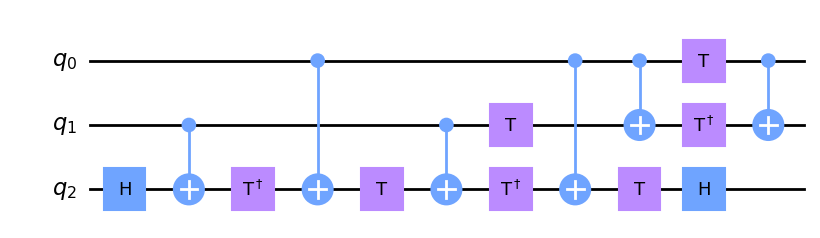

In [7]:
cir3=QuantumCircuit(3)
cir3.ccx(0,1,2)
cir3=transpile(cir3,basis_gates=['h', 't', 'tdg', 'cx'])
cir3.draw('mpl')

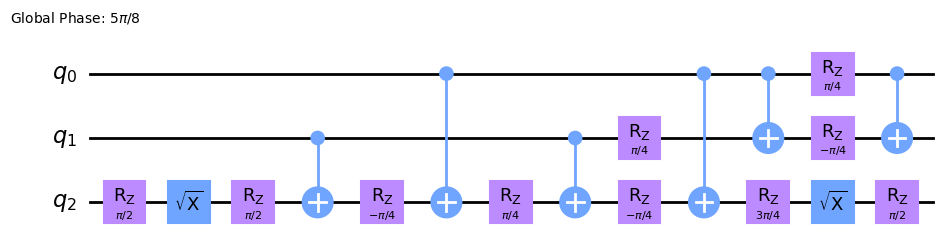

In [8]:
cir4=transpile(cir3,basis_gates=['id', 'rz', 'sx', 'x', 'cx'])
cir4.draw('mpl')

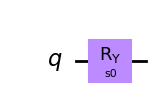

In [9]:
s0=Parameter('s%i'%0)
simple=QuantumCircuit(1)
# simple.rz(s0,0)

# simple.rz(-s0,0)

# simple.rx(s0,0)

simple.ry(s0,0)


simple.draw('mpl')

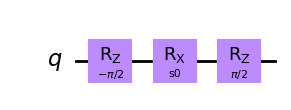

In [10]:
simple2=QuantumCircuit(1)

# simple2.rx(-np.pi/2,0)
# simple2.ry(s0,0)
# simple2.rx(np.pi/2,0)

# simple2.ry(-np.pi/2,0)
# simple2.rx(s0,0)
# simple2.ry(np.pi/2,0)

# simple2.ry(-np.pi/2,0)
# simple2.rz(s0,0)
# simple2.ry(np.pi/2,0)

simple2.rz(-np.pi/2,0)
simple2.rx(s0,0)
simple2.rz(np.pi/2,0)
simple2.draw('mpl')

In [11]:
def experiment(qubit_num=2,reps=1,function='RealAmplitudes', optimizer=None, file_name=None):
        cir1,cir2,circuit_nam=circuit_generator(qubit_num=qubit_num,reps=reps,function_name=function)
        tdd1,output_dict1=STDD_simulation(cir1, unique_table_reset=True, optimizer=optimizer)
        tdd2,output_dict2=STDD_simulation(cir2, unique_table_reset=False, optimizer=optimizer)
        output_dict3=verify(tdd1,tdd2)
        if file_name:
                with open(file_name, 'a', newline='') as csvfile:
                        fieldnames = ['Benchmark Name','Parameter num.','Qubit num.'
                                ,'Gate num._1','Time_1','Node num. max_1','Node num. final_1','gu1_1','gu2_1'
                                ,'Gate num._2','Time_2','Node num. max_2','Node num. final_2','gu1_2','gu2_2'
                                ,'Check_time','Totol_time','Equivalent']
                        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                        writer.writerow({'Benchmark Name':circuit_nam,'Parameter num.':output_dict1['Parameter num'],'Qubit num.':output_dict1['Qubit num.']
                        ,'Gate num._1':output_dict1['Gate num.'],'Time_1':output_dict1['Time'],'Node num. max_1':output_dict1['Node num. max']
                        ,'Node num. final_1':output_dict1['Node num. final'],'gu1_1':output_dict1['gu1'],'gu2_1':output_dict1['gu2']
                        ,'Gate num._2':output_dict2['Gate num.'],'Time_2':output_dict2['Time'],'Node num. max_2':output_dict2['Node num. max']
                        ,'Node num. final_2':output_dict2['Node num. final'],'gu1_2':output_dict2['gu1'],'gu2_2':output_dict2['gu2']
                        ,'Check_time':output_dict3['check_time'],'Totol_time':output_dict1['Time']+output_dict2['Time']+output_dict3['check_time']
                        ,'Equivalent':output_dict3['equivalence']})
        return {'Benchmark Name':circuit_nam,'Parameter num.':output_dict1['Parameter num'],'Qubit num.':output_dict1['Qubit num.']
                ,'Gate num._1':output_dict1['Gate num.'],'Time_1':output_dict1['Time'],'Node num. max_1':output_dict1['Node num. max']
                ,'Node num. final_1':output_dict1['Node num. final'],'gu1_1':output_dict1['gu1'],'gu2_1':output_dict1['gu2']
                ,'Gate num._2':output_dict2['Gate num.'],'Time_2':output_dict2['Time'],'Node num. max_2':output_dict2['Node num. max']
                ,'Node num. final_2':output_dict2['Node num. final'],'gu1_2':output_dict2['gu1'],'gu2_2':output_dict2['gu2']
                ,'Check_time':output_dict3['check_time'],'Totol_time':output_dict1['Time']+output_dict2['Time']+output_dict3['check_time']
                ,'Equivalent':output_dict3['equivalence']}



In [12]:
tdd1, output_dict=STDD_simulation(simple)
tdd2, output_dict=STDD_simulation(simple2,unique_table_reset=False)

verify(tdd1,tdd2)

{'check_time': 3.0994415283203125e-06, 'equivalence': 'equivalent'}

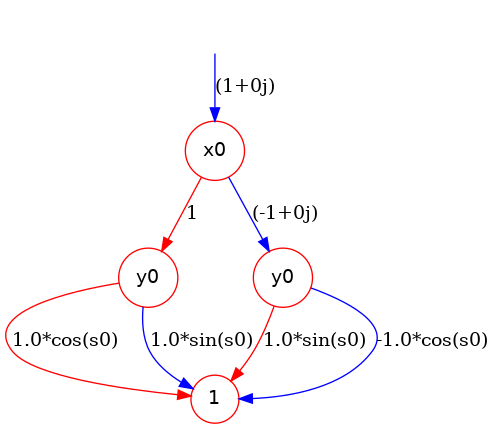

In [13]:
tdd1.show()

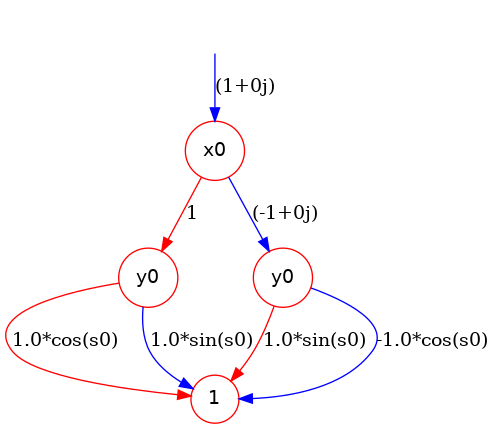

In [14]:
tdd2.show()

In [15]:
tdd, output_dict=STDD_verify(simple, simple2)
output_dict

{'Benchmark Name': None,
 'Parameter num.': 1,
 'Qubit num.': 1,
 'Gate num.': 1,
 'Node num. max': 4,
 'Node num. final': 4,
 'gu1': 16,
 'gu2': 6,
 'Equivalent': 'equivalent',
 'Time': 0.003538370132446289}

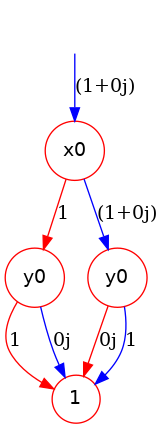

In [16]:
tdd.show()

In [17]:
experiment(qubit_num=2,reps=1 ,function='TwoLocal')

{'Benchmark Name': 'TwoLocal_2_1',
 'Parameter num.': 4,
 'Qubit num.': 2,
 'Gate num._1': 17,
 'Time_1': 0.04158616065979004,
 'Node num. max_1': 16,
 'Node num. final_1': 16,
 'gu1_1': 155,
 'gu2_1': 153,
 'Gate num._2': 5,
 'Time_2': 0.01153421401977539,
 'Node num. max_2': 16,
 'Node num. final_2': 16,
 'gu1_2': 163,
 'gu2_2': 189,
 'Check_time': 2.86102294921875e-06,
 'Totol_time': 0.05312323570251465,
 'Equivalent': 'equivalent'}

In [18]:
cir, cir2, Benchmark_Name = circuit_generator(qubit_num=5,reps=4, function_name='EfficientSU2'
                                ,basis_gates1=['rx', 'ry', 'rz','cz']
                                ,basis_gates2=['rx','ry','rz','cx'])

In [19]:
from TDD.TDD import empty_tdd_list
empty_tdd_list()
tdd, output_dict=STDD_verify2(cir, cir2)
output_dict

{'Benchmark Name': None,
 'Parameter num.': 25,
 'Qubit num.': 5,
 'Gate num.': 111,
 'Node num. max': 20,
 'Node num. final': 16,
 'gu1': 565,
 'gu2': 126,
 'Equivalent': 'equivalent',
 'Time': 0.17950224876403809}

211


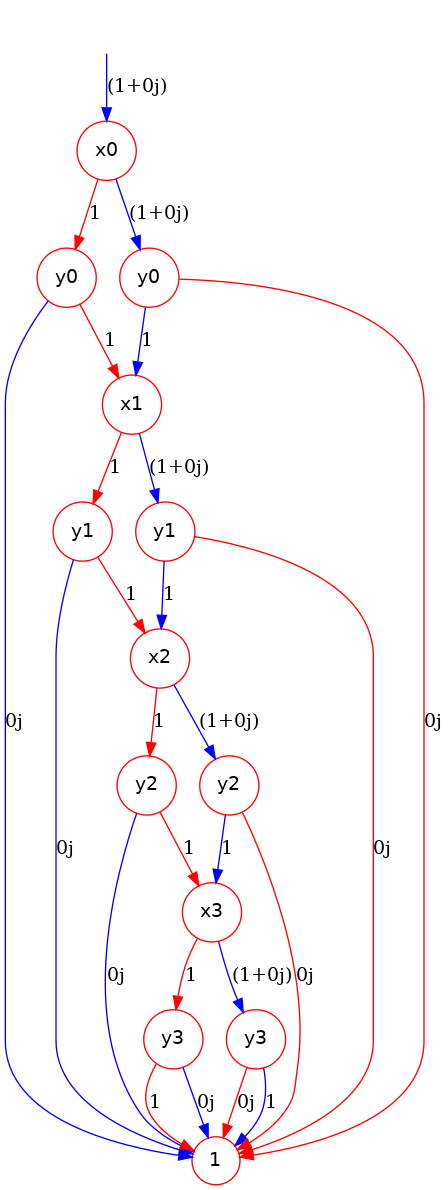

In [20]:
from TDD.TDD import get_tdd_list
tdd_list = get_tdd_list()
print(len(tdd_list))
k=210

tdd_list[k][0].show()

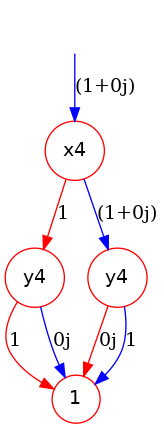

In [21]:
tdd_list[k][1].show()


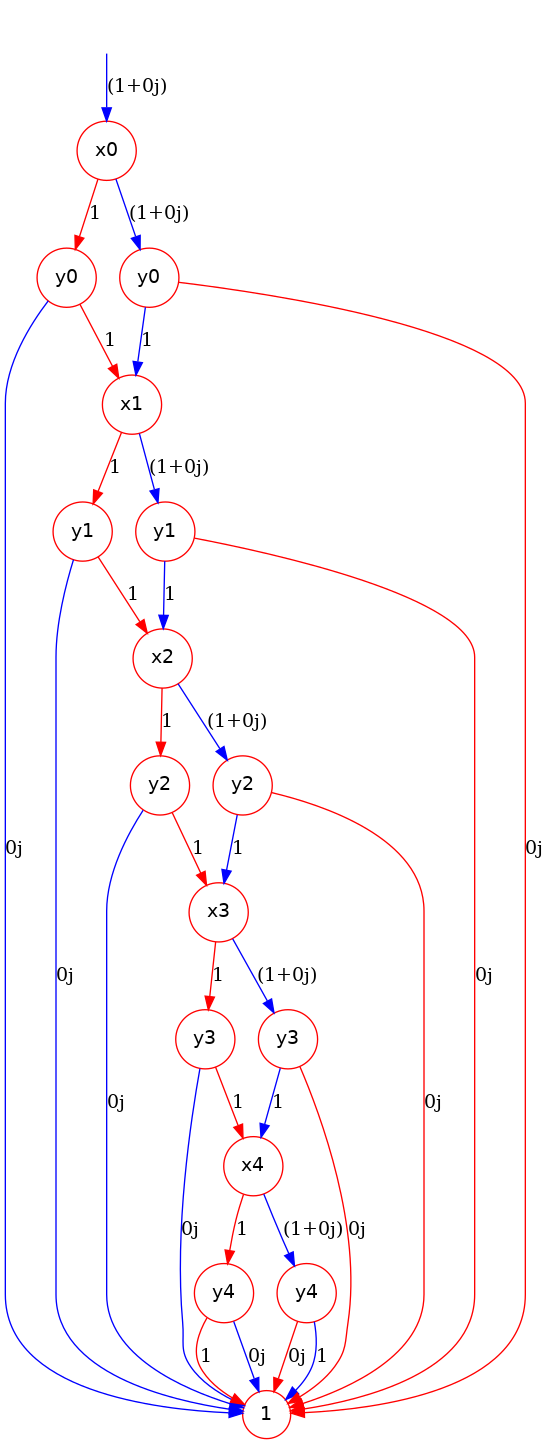

In [22]:
tdd_list[k][2].show()


In [23]:
tdd, output_dict=STDD_verify(simple, simple2)
output_dict

{'Benchmark Name': None,
 'Parameter num.': 1,
 'Qubit num.': 1,
 'Gate num.': 1,
 'Node num. max': 4,
 'Node num. final': 4,
 'gu1': 16,
 'gu2': 6,
 'Equivalent': 'equivalent',
 'Time': 0.0051288604736328125}

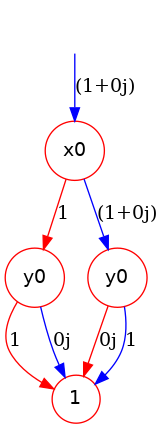

In [24]:
tdd.show()

In [25]:
from mqt import qcec

qcec.verify(cir, cir2)

{
  "check_time": 0.001935016,
  "equivalence": "equivalent",
  "parameterized": {
    "performed_instantiations": 0
  },
  "preprocessing_time": 0.000215401
}

In [26]:
qcec.verify(simple, simple2
            # , additional_instantiations=10
            )

{
  "check_time": 8.5501e-05,
  "equivalence": "equivalent_up_to_global_phase",
  "parameterized": {
    "performed_instantiations": 0
  },
  "preprocessing_time": 0.000220102
}

In [27]:
# tdd.show()

# Compare

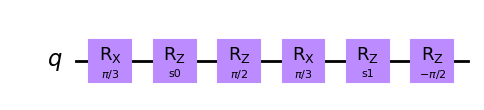

In [28]:
s0=Parameter('s%i'%0)
s1=Parameter('s%i'%1)
test=QuantumCircuit(1)
test.rx(np.pi/3,0)
test.rz(s0,0)
test.rz(np.pi/2,0)
test.rx(np.pi/3,0)
test.rz(s1,0)
test.rz(-np.pi/2,0)

test.draw('mpl')

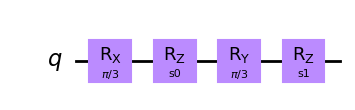

In [29]:
test2=QuantumCircuit(1)
test2.rx(np.pi/3,0)
test2.rz(s0,0)
test2.ry(np.pi/3,0)
test2.rz(s1,0)

test2.draw('mpl')

In [30]:
tdd, output_dict=STDD_verify(test, test2)
output_dict

{'Benchmark Name': None,
 'Parameter num.': 2,
 'Qubit num.': 1,
 'Gate num.': 6,
 'Node num. max': 4,
 'Node num. final': 4,
 'gu1': 35,
 'gu2': 39,
 'Equivalent': 'not_equivalent',
 'Time': 0.014028549194335938}

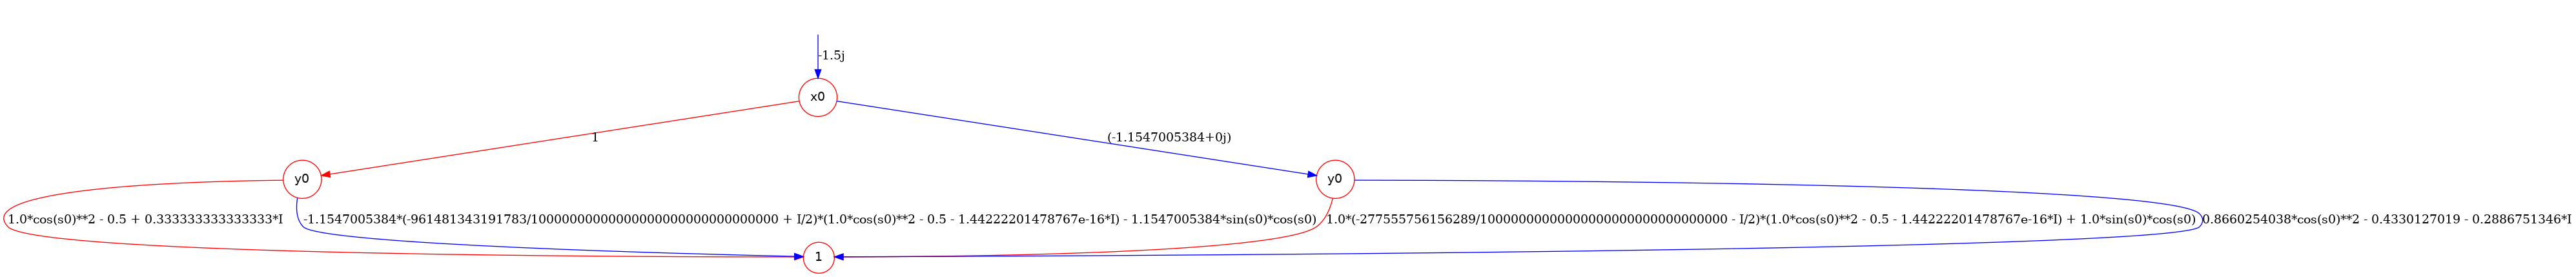

In [31]:
tdd.show()

In [32]:
qcec.verify(test, test2)

{
  "check_time": 0.0075040639999999995,
  "equivalence": "not_equivalent",
  "parameterized": {
    "performed_instantiations": 1
  },
  "preprocessing_time": 0.000461004,
  "simulations": {
    "performed": 0,
    "started": 2
  }
}

In [33]:
# import sympy

# x = sympy.Symbol('x')
# y = sympy.Symbol('y')
# epi=1e-10
# expr = (1e-15 + 2j)*x + (3 + 4j)*x*y

# new_expr=0
# for term in expr.args:
#     # print(term)
#     free_symbols=term.free_symbols
#     for i in range(len(free_symbols)):
#         if i==0:
#             coeff = term.coeff(free_symbols.pop())
#         else:
#             coeff = coeff.coeff(free_symbols.pop())
#     if abs(coeff)-abs(coeff.as_real_imag()[0]) < epi:
#         coeff=coeff.as_real_imag()[0]
#     elif abs(coeff)-abs(coeff.as_real_imag()[1]) < epi:
#         coeff=coeff.as_real_imag()[1] * sympy.I
#     symbols = term.free_symbols
#     terms=1 
#     for symbol in symbols:
#         terms*=symbol
#     # print('term',coeff*terms)
#     new_expr+=coeff*terms
# print('solution',new_expr)


In [34]:

# with open('STDD cir_partition2 benchmark.csv', 'w', newline='') as csvfile:
#     fieldnames=['Benchmark Name','Parameter num.','Qubit num.'
# ,'Gate num._1','Time_1','Node num. max_1','Node num. final_1','gu1_1','gu2_1'
# ,'Gate num._2','Time_2','Node num. max_2','Node num. final_2','gu1_2','gu2_2'
# ,'Check_time','Totol_time','Equivalent']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()


In [35]:
# function_list=['RealAmplitudes','EfficientSU2']
# experiment_setup=[(5,3)]
    
# for qubit_num,reps in experiment_setup:
#     for function in function_list:
#             experiment(qubit_num=qubit_num, reps=reps, function=function, optimizer=None, file_name='STDD benchmark.csv')
        

In [36]:

# import csv
# with open('./output_dict/STDD benchmark_Standard D8s v3 0628.csv', 'w', newline='') as csvfile:
#     fieldnames=['Benchmark Name','Parameter num.','Qubit num.'
# ,'Gate num.','Node num. max','Node num. final','gu1','gu2','Equivalent','Time'
# ]
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()


In [37]:

def experiment2(function_name ='EfficientSU2', qubit_num = 2, reps = 0, file_name='STDD benchmark.csv'):
    cir,cir2,Benchmark_Name = circuit_generator(qubit_num = qubit_num, reps=reps, function_name = function_name
                                    ,basis_gates1=['rx', 'ry', 'rz','cz']
                                    ,basis_gates2=['rx', 'ry','rz','cx'])
    tdd, output_dict = STDD_verify2(cir, cir2, Benchmark_Name = Benchmark_Name , unique_table_reset=True, add_inputs_list=None, optimizer=None)
    with open(file_name, 'a', newline='') as csvfile:
        fieldnames = ['Benchmark Name','Parameter num.','Qubit num.'
        ,'Gate num.','Node num. max','Node num. final','gu1','gu2','Equivalent','Time']

        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow(output_dict)


In [38]:
from mqt import qcec

function_name ='TwoLocal'
qubit_num = 64
reps = 3

cir,cir2,Benchmark_Name=circuit_generator(qubit_num = qubit_num, reps=reps, function_name = function_name, basis_gates1=['rx', 'ry', 'sx','cx']
                                ,basis_gates2=['rx','sx','rz','cx'])
# cir.draw()
qcec.verify(cir, cir2)



{
  "check_time": 0.110467535,
  "equivalence": "equivalent_up_to_global_phase",
  "parameterized": {
    "performed_instantiations": 0
  },
  "preprocessing_time": 0.000318103
}

In [39]:
import json
with open('../../../quartz/test_3_2_5_complete_ECC_set.json') as f:
    data = json.load(f)
    gate_list1=data[1]['12_2'][0][1]
    gate_list2=data[1]['12_2'][1][1]
print(gate_list1,"\n",gate_list2)


[['h', ['Q0'], ['Q0']], ['t', ['Q0'], ['Q0']], ['t', ['Q0'], ['Q0']], ['rx', ['Q0'], ['Q0', 'P1']], ['rz', ['Q0'], ['Q0', 'P0']]] 
 [['ry', ['Q0'], ['Q0', 'P1']], ['h', ['Q0'], ['Q0']], ['rz', ['Q0'], ['Q0', 'P0']], ['t', ['Q0'], ['Q0']], ['t', ['Q0'], ['Q0']]]


In [40]:
import random
def quartz_to_qiskit(gate_list):
    cir = QuantumCircuit(1)
    P0 = Parameter("P0")
    P1 = Parameter("P1")
    P_list=[P0,P1]
    def gete_P(gate):
        P_str = gate[-1][-1]
        return P_list[int(P_str [1:])]
    
    for gate in gate_list:
        gate_name = gate[0]
        if gate_name == "h":
            cir.h(0)
        if gate_name == "t":
            cir.t(0)
        if gate_name == "rx":
            cir.rx(gete_P(gate), 0)
        if gate_name == "ry":
            cir.ry(gete_P(gate), 0)
        if gate_name == "rz":
            cir.rz(gete_P(gate), 0)   
    return cir
cir = quartz_to_qiskit(gate_list1)
cir.draw()

┌───┐┌───┐┌───┐┌────────┐┌────────┐
q: ┤ H ├┤ T ├┤ T ├┤ Rx(P1) ├┤ Rz(P0) ├
   └───┘└───┘└───┘└────────┘└────────┘

In [41]:
cir2 = quartz_to_qiskit(gate_list2)
cir2.draw()

┌────────┐┌───┐┌────────┐┌───┐┌───┐
q: ┤ Ry(P1) ├┤ H ├┤ Rz(P0) ├┤ T ├┤ T ├
   └────────┘└───┘└────────┘└───┘└───┘

In [42]:
cir = quartz_to_qiskit(gate_list1)
cir2 = quartz_to_qiskit(gate_list2)
qcec.verify(cir, cir2)

{
  "check_time": 0.000104501,
  "equivalence": "equivalent_up_to_global_phase",
  "parameterized": {
    "performed_instantiations": 0
  },
  "preprocessing_time": 0.000214202
}

In [43]:
import math
from qiskit.extensions import UnitaryGate
U=np.array([[math.sqrt(3)/3,-math.sqrt(6)/3],
   [math.sqrt(6)/3,math.sqrt(3)/3]])
cir =QuantumCircuit(1)
op = UnitaryGate(U)
opdg = op.adjoint()
cir.append(op, [0])
cir.append(opdg, [0])
cir.draw()


┌─────────┐┌─────────┐
q: ┤ Unitary ├┤ Unitary ├
   └─────────┘└─────────┘

In [44]:
cir2 =QuantumCircuit(1)

cir2.h(0)
cir2.h(0)
cir2.draw()

┌───┐┌───┐
q: ┤ H ├┤ H ├
   └───┘└───┘

In [45]:
qcec.verify(cir, cir2)

{
  "check_time": 0.000318403,
  "equivalence": "equivalent_up_to_global_phase",
  "parameterized": {
    "performed_instantiations": 0
  },
  "preprocessing_time": 0.000228502,
  "simulations": {
    "performed": 0,
    "started": 2
  }
}

In [46]:
'''stdd verify experiment'''
function_list=['EfficientSU2','TwoLocal','RealAmplitudes']
experiment_setup=[(64,2)]


# for i in range(5):
for qubit_num,reps in experiment_setup:
    for function_name in function_list:
        experiment2(function_name = function_name, qubit_num = qubit_num, reps = reps, file_name='./output_dict/STDD benchmark_Standard D8s v3_0628.csv')

In [47]:
# function_name = 'TwoLocal'
# qubit_num, reps = (5, 3 )

# cir,cir2, Benchmark_Name =circuit_generator(qubit_num = qubit_num, reps=reps, function_name = function_name
#                                     ,basis_gates1=['rx', 'ry', 'rz','cz']
#                                     ,basis_gates2=['rx', 'ry','rz','cx'])

# tdd, output_dict = STDD_verify(cir, cir2, Benchmark_Name = Benchmark_Name , unique_table_reset=True, add_inputs_list=None, optimizer=None)

# output_dict